# Making embeddings for layoutLM

在layoutLMv2中，有Processor这个库把所有的预处理都做了，只需要传入图片即可

## OCR Parser/PDF parser

    if picPDF - use pytesseract

    if textPDF - use pdfplumber

get text layout embeddings

### get raw layout information - json format

In [1]:
# get all pdf files in the dir
import os

def find_all_pdf(pdir):
    pdfname = []
    pdfdir = []
    for root,ds,fs in os.walk(pdir):
        for f in fs:
            if "Presentation" not in str(f) or "parser" in str(f):
                continue
            pdfname.append(str(f).strip(".pdf"))
            pdfdir.append(str(root)+"/"+str(f))
    return pdfname,pdfdir
    
pname,pdir = find_all_pdf("./")
pdir

['./acl2017/P17-1014.Presentation.pdf',
 './acl2017/P17-1031.Presentation.pdf',
 './acl2017/P17-1039.Presentation.pdf',
 './acl2017/P17-1042.Presentation.pdf',
 './acl2017/P17-1049.Presentation.pdf',
 './acl2017/P17-1051.Presentation.pdf',
 './acl2017/P17-1054.Presentation.pdf',
 './acl2017/P17-1057.Presentation.pdf',
 './acl2017/P17-1061.Presentation.pdf',
 './acl2017/P17-1066.Presentation.pdf',
 './acl2017/P17-1068.Presentation.pdf',
 './acl2017/P17-1072.Presentation.pdf',
 './acl2017/P17-1099.Presentation.pdf',
 './acl2017/P17-1104.Presentation.pdf',
 './acl2017/P17-1116.Presentation.pdf',
 './acl2017/P17-1167.Presentation.pdf',
 './acl2017/P17-2015.Presentation.pdf',
 './acl2017/P17-2017.Presentation.pdf',
 './acl2017/P17-2021.Presentation.pdf',
 './acl2017/P17-2070.Presentation.pdf',
 './acl2018/P18-1001.Presentation.pdf',
 './acl2018/P18-1002.Presentation.pdf',
 './acl2018/P18-1004.Presentation.pdf',
 './acl2018/P18-1005.Presentation.pdf',
 './acl2018/P18-1008.Presentation.pdf',


In [16]:
def write2json(data, file_path):
    '''write a dict to jsonfile'''
    with open(file_path, "a+", encoding="utf-8") as f_out:
        f_out.write("{}\n".format(json.dumps(data, ensure_ascii=False)))
    return

In [27]:
str1 = './acl2018/P18-2103.Presentation.pdf'
str1.strip(".pdf").split("/")[2]

'P18-2103.Presentation'

In [20]:
import pdfplumber
with pdfplumber.open("./acl2017/P17-1014.Presentation.pdf") as pdf:
    page = pdf.pages[0]
    for item in page.chars:
        print(type(item))
        print(item)
        break

<class 'dict'>
{'fontname': 'AZKQCZ+Helvetica-Bold', 'adv': Decimal('0.722'), 'upright': True, 'x0': Decimal('109.000'), 'y0': Decimal('424.960'), 'x1': Decimal('143.656'), 'y1': Decimal('472.960'), 'width': Decimal('34.656'), 'height': Decimal('48.000'), 'size': Decimal('48.000'), 'object_type': 'char', 'page_number': 1, 'stroking_color': None, 'non_stroking_color': [0, 0, 0], 'text': 'N', 'top': Decimal('295.040'), 'bottom': Decimal('343.040'), 'doctop': Decimal('295.040')}


In [29]:
import pdfplumber
for file in pdir:
    with pdfplumber.open(file) as pdf:
        for page in pdf.pages:
            for item in page.chars:
                new_dic = {}
                new_dic["text"] = str(item["text"])
                new_dic["x0"] = float(item["x0"])
                new_dic["y0"] = float(item["y0"])
                new_dic["x1"] = float(item["x1"])
                new_dic["y1"] = float(item["y1"])
                new_dic["size"] = float(item["size"])
                new_dic["width"] = float(item["width"])
                new_dic["height"] = float(item["height"])
                new_dic["top"] = float(item["top"])
                new_dic["bottom"] = float(item["bottom"])
                new_dic["doctop"] = float(item["doctop"])
                new_dic["fontname"] = str(item["fontname"])
                new_dic["page_number"] = int(item["page_number"])
                write2json(new_dic,file.strip(".pdf").split("/")[2] + "_parserResult.json")

### get layout embeddings

layoutLMv1中直接输入text token级别的对应layout vector，可以根据情况来看看需不需要做归一化，故不需要太特殊处理。

v2中的处理较为复杂，将所有坐标，标准化和离散化为[0-1000]范围内的整数，并且使用两个embedding分别embed X轴的特征和Y轴的特征，对于normalized后的bounding box（x0,x1,y0,y1,w,h），layout embedding的做法就是把6个bounding box的特征给concate起来做成token-level layout embedding

In [ ]:
def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

In [1]:
# get layoutLMv2 - layoutEmbeddings

## Faster_R_CNN

use resnet to get image-token embedding

first : transfer the pdf file into image png

In [2]:
from pdf2image import convert_from_path

In [4]:
from tqdm import tqdm
for index,path in tqdm(enumerate(pdir)):
    print("path",path)
    im = convert_from_path(path)
    for i,pic in enumerate(im):
        print("i",i)
        pic.save(f"./acl_ppt_images/{pname[index]}_{i}.png")

0it [00:00, ?it/s]

path ./acl2017/P17-1014.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90
i 91
i 92
i 93
i 94
i 95
i 96
i 97
i 98
i 99
i 100
i 101
i 102
i 103
i 104
i 105
i 106
i 107
i 108
i 109
i 110
i 111
i 112
i 113
i 114
i 115


1it [06:21, 381.63s/it]

path ./acl2017/P17-1031.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24


2it [06:24, 159.08s/it]

i 25
i 26
i 27
i 28
path ./acl2017/P17-1039.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32


3it [06:38, 92.60s/it] 

i 33
path ./acl2017/P17-1042.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90
i 91
i 92
i 93
i 94
i 95
i 96
i 97
i 98
i 99
i 100
i 101
i 102
i 103
i 104
i 105
i 106
i 107
i 108
i 109
i 110
i 111
i 112
i 113
i 114
i 115
i 116
i 117
i 118
i 119
i 120
i 121
i 122
i 123
i 124
i 125
i 126
i 127
i 128
i 129
i 130
i 131
i 132
i 133


4it [07:43, 81.60s/it]

i 134
path ./acl2017/P17-1049.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16


5it [07:51, 55.17s/it]

path ./acl2017/P17-1051.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37


6it [08:02, 40.31s/it]

i 38
path ./acl2017/P17-1054.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20


7it [08:47, 41.59s/it]

path ./acl2017/P17-1057.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23


8it [09:05, 34.10s/it]

path ./acl2017/P17-1061.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


9it [09:14, 26.21s/it]

i 28
path ./acl2017/P17-1066.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28


10it [09:27, 22.20s/it]

path ./acl2017/P17-1068.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i

11it [09:30, 16.43s/it]

 31
path ./acl2017/P17-1072.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i

12it [09:55, 19.00s/it]

 29
path ./acl2017/P17-1099.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30


13it [10:06, 16.56s/it]

i 31
path ./acl2017/P17-1104.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i

14it [10:12, 13.52s/it]

 70
path ./acl2017/P17-1116.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49


15it [10:33, 15.70s/it]

path ./acl2017/P17-1167.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22


16it [10:48, 15.38s/it]

path ./acl2017/P17-2015.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11


17it [10:55, 13.00s/it]

path ./acl2017/P17-2017.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46


18it [12:47, 42.80s/it]

path ./acl2017/P17-2021.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86


19it [14:21, 57.97s/it]

path ./acl2017/P17-2070.Presentation.pdf
i 0


20it [14:30, 43.26s/it]

path ./acl2018/P18-1001.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32


21it [14:54, 37.64s/it]

path ./acl2018/P18-1002.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43


22it [15:17, 33.22s/it]

i 44
path ./acl2018/P18-1004.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21


23it [15:33, 27.84s/it]

path ./acl2018/P18-1005.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13


24it [15:47, 23.93s/it]

path ./acl2018/P18-1008.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17


25it [15:54, 18.84s/it]

i 18
path ./acl2018/P18-1009.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56


26it [18:30, 60.00s/it]

path ./acl2018/P18-1011.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23


27it [18:37, 44.02s/it]

i 24
path ./acl2018/P18-1012.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61


28it [19:37, 48.94s/it]

path ./acl2018/P18-1013.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i

29it [20:17, 46.25s/it]

 62
path ./acl2018/P18-1015.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25


30it [20:20, 33.09s/it]

path ./acl2018/P18-1016.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43


31it [20:36, 28.16s/it]

i 44
path ./acl2018/P18-1017.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47


32it [22:38, 56.31s/it]

path ./acl2018/P18-1018.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28


33it [22:51, 43.21s/it]

path ./acl2018/P18-1021.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76


34it [23:48, 47.35s/it]

path ./acl2018/P18-1022.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42


35it [24:03, 37.65s/it]

path ./acl2018/P18-1069.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i

36it [24:16, 30.27s/it]

 23
path ./acl2018/P18-1071.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i

37it [25:08, 36.78s/it]

 81
path ./acl2018/P18-1072.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90
i 91
i 92
i 93
i 94
i 95
i 96
i 97


38it [26:51, 56.66s/it]

path ./acl2018/P18-1073.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90
i 91
i 92
i 93
i 94
i 95
i 96
i 97
i 98
i 99
i 100
i 101
i 102
i 103
i 104
i 105
i 106
i 107
i 108
i 109
i 110
i 111
i 112
i 113
i 114
i 115
i 116
i 117
i 118
i 119
i 120
i 121
i 122
i 123
i 124
i 125
i 126
i 127
i 128
i 129
i 130
i 131
i 132
i 133
i 134
i 135
i 136
i 137
i 138
i 139
i 140
i 141
i 142
i 143


39it [28:03, 61.26s/it]

path ./acl2018/P18-1074.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26


40it [28:29, 50.54s/it]

path ./acl2018/P18-1075.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i

41it [28:32, 36.35s/it]

 28
i 29
path ./acl2018/P18-1078.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


42it [28:46, 29.61s/it]

path ./acl2018/P18-1079.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46


43it [29:44, 38.20s/it]

path ./acl2018/P18-1081.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19


44it [29:56, 30.18s/it]

path ./acl2018/P18-1083.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20


45it [30:08, 24.95s/it]

i 21
path ./acl2018/P18-1084.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36


46it [30:28, 23.48s/it]

path ./acl2018/P18-1086.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34


47it [30:56, 24.85s/it]

path ./acl2018/P18-1087.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


48it [30:59, 18.21s/it]

path ./acl2018/P18-1089.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9


49it [31:02, 13.68s/it]

path ./acl2018/P18-1090.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33


50it [31:19, 14.62s/it]

path ./acl2018/P18-1091.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22


51it [31:33, 14.36s/it]

path ./acl2018/P18-1092.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42


52it [33:31, 45.63s/it]

path ./acl2018/P18-1093.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10


53it [33:41, 34.72s/it]

i 11
path ./acl2018/P18-1094.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i

54it [33:48, 26.57s/it]

 28
path ./acl2018/P18-1096.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90
i 91
i 92
i 93
i 94
i 95
i 96
i 97
i 98
i 99
i 100
i 101
i 102
i 103
i 104
i 105
i 106
i 107
i 108
i 109
i 110
i 111


55it [36:25, 65.49s/it]

path ./acl2018/P18-1099.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32


56it [36:48, 52.99s/it]

path ./acl2018/P18-1100.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36


57it [37:10, 43.47s/it]

path ./acl2018/P18-1101.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26


58it [37:19, 33.30s/it]

i 27
path ./acl2018/P18-1102.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23


59it [37:29, 26.39s/it]

path ./acl2018/P18-1103.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33


60it [37:58, 27.04s/it]

path ./acl2018/P18-1105.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17


61it [38:10, 22.57s/it]

i 18
path ./acl2018/P18-1106.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66


62it [38:32, 22.37s/it]

path ./acl2018/P18-1108.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34


63it [38:52, 21.53s/it]

path ./acl2018/P18-1110.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81


64it [39:23, 24.45s/it]

path ./acl2018/P18-1111.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73


65it [39:29, 18.99s/it]

i 74
i 75
path ./acl2018/P18-1112.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18


66it [39:38, 15.93s/it]

path ./acl2018/P18-1113.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43


67it [40:27, 25.88s/it]

path ./acl2018/P18-1114.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29


68it [41:32, 37.50s/it]

path ./acl2018/P18-1116.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60


69it [42:34, 45.12s/it]

path ./acl2018/P18-1117.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61


70it [45:24, 82.34s/it]

path ./acl2018/P18-1118.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77


71it [45:36, 61.29s/it]

path ./acl2018/P18-1119.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11


72it [45:49, 46.71s/it]

path ./acl2018/P18-1122.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22


73it [45:59, 35.83s/it]

path ./acl2018/P18-1123.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11


74it [46:05, 26.92s/it]

path ./acl2018/P18-1126.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55


75it [46:36, 27.97s/it]

i 56
path ./acl2018/P18-1127.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18


76it [46:57, 26.04s/it]

i 19
i 20
path ./acl2018/P18-1128.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21


77it [47:09, 21.75s/it]

path ./acl2018/P18-1129.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24


78it [47:27, 20.79s/it]

path ./acl2018/P18-1130.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33


79it [47:57, 23.35s/it]

path ./acl2018/P18-1132.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51


80it [49:20, 41.46s/it]

path ./acl2018/P18-1168.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29


81it [49:44, 36.11s/it]

path ./acl2018/P18-1169.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17


82it [49:47, 26.21s/it]

path ./acl2018/P18-1170.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48


83it [50:26, 30.01s/it]

path ./acl2018/P18-1171.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29


84it [50:49, 27.99s/it]

path ./acl2018/P18-1173.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53


85it [51:37, 33.87s/it]

path ./acl2018/P18-1174.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29


86it [52:15, 35.01s/it]

path ./acl2018/P18-1175.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35


87it [52:31, 29.37s/it]

path ./acl2018/P18-1176.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32


88it [52:43, 24.23s/it]

path ./acl2018/P18-1178.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44


89it [52:57, 21.10s/it]

i 45
path ./acl2018/P18-1179.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i

90it [53:03, 16.78s/it]

 68
path ./acl2018/P18-1180.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90


91it [53:43, 23.60s/it]

i 91
path ./acl2018/P18-1181.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i

92it [53:46, 17.29s/it]

 19
path ./acl2018/P18-1182.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46


93it [54:20, 22.54s/it]

i 47
path ./acl2018/P18-1183.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33


94it [54:25, 17.18s/it]

i 34
path ./acl2018/P18-1184.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


95it [54:40, 16.46s/it]

path ./acl2018/P18-1185.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21


96it [54:56, 16.41s/it]

i 22
path ./acl2018/P18-1187.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24


97it [55:00, 12.59s/it]

path ./acl2018/P18-1188.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79


98it [56:03, 27.73s/it]

path ./acl2018/P18-1189.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45


99it [56:08, 20.98s/it]

path ./acl2018/P18-1190.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15


100it [56:10, 15.36s/it]

i 16
path ./acl2018/P18-1191.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90


101it [57:49, 40.27s/it]

path ./acl2018/P18-1192.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16


102it [57:57, 30.61s/it]

path ./acl2018/P18-1193.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79


103it [59:20, 46.35s/it]

path ./acl2018/P18-1194.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


104it [59:30, 35.51s/it]

path ./acl2018/P18-1195.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i

105it [59:43, 28.70s/it]

 44
i 45
path ./acl2018/P18-1196.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37


106it [59:57, 24.33s/it]

i 38
path ./acl2018/P18-1197.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23


107it [1:00:08, 20.21s/it]

i 24
path ./acl2018/P18-1198.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


108it [1:00:23, 18.75s/it]

path ./acl2018/P18-1199.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


109it [1:00:36, 16.88s/it]

path ./acl2018/P18-1200.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22


110it [1:00:43, 14.14s/it]

path ./acl2018/P18-1201.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18


111it [1:00:52, 12.45s/it]

path ./acl2018/P18-1202.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27


112it [1:00:55,  9.67s/it]

i 28
i 29
path ./acl2018/P18-1203.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25


113it [1:01:14, 12.34s/it]

path ./acl2018/P18-1204.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42


114it [1:01:35, 14.97s/it]

path ./acl2018/P18-1207.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20


115it [1:01:45, 13.68s/it]

path ./acl2018/P18-1209.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25


116it [1:02:08, 16.31s/it]

path ./acl2018/P18-1210.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30


117it [1:02:34, 19.42s/it]

path ./acl2018/P18-1212.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21


118it [1:02:45, 16.67s/it]

path ./acl2018/P18-1213.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33


119it [1:02:55, 14.90s/it]

i 34
path ./acl2018/P18-1255.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90
i 91
i 92
i 93
i 94
i 95
i 96
i 97
i 98
i 99
i 100
i 101
i 102
i 103
i 104
i 105
i 106
i 107
i 108
i 109
i

120it [1:04:06, 31.66s/it]

 110
path ./acl2018/P18-1256.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39


121it [1:04:44, 33.63s/it]

path ./acl2018/P18-2100.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17


122it [1:05:14, 32.48s/it]

path ./acl2018/P18-2101.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13


123it [1:05:19, 24.22s/it]

path ./acl2018/P18-2102.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15


124it [1:05:21, 17.55s/it]

i 16
i 17
i 18
path ./acl2018/P18-2103.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37


125it [1:05:25, 13.32s/it]

i 38
path ./acl2018/P18-2104.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16


126it [1:05:44, 15.25s/it]

path ./acl2018/P18-2105.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33


127it [1:05:55, 13.76s/it]

path ./acl2018/P18-2107.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38


128it [1:06:46, 25.11s/it]

path ./acl2018/P18-2108.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24


129it [1:06:55, 20.26s/it]

path ./acl2018/P18-2109.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i

130it [1:07:03, 16.45s/it]

 41
path ./acl2018/P18-2110.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23


131it [1:07:19, 16.39s/it]

path ./acl2018/P18-2111.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14


132it [1:07:27, 13.85s/it]

path ./acl2018/P18-2112.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16


133it [1:07:36, 12.35s/it]

path ./acl2018/P18-2113.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i

134it [1:07:40,  9.80s/it]

 36
i 37
i 38
path ./acl2018/P18-2114.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48
i 49
i 50
i 51
i 52
i 53
i 54
i 55
i 56
i 57
i 58
i 59
i 60
i 61
i 62
i 63
i 64
i 65
i 66
i 67
i 68
i 69
i 70
i 71
i 72
i 73
i 74
i 75
i 76
i 77
i 78
i 79
i 80
i 81
i 82
i 83
i 84
i 85
i 86
i 87
i 88
i 89
i 90
i 91
i 92
i 93
i 94


135it [1:09:24, 38.27s/it]

path ./acl2018/P18-2117.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48


136it [1:10:13, 41.35s/it]

path ./acl2019/P19-1015.Presentation.pdf
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19
i 20
i 21
i 22
i 23
i 24
i 25
i 26
i 27
i 28
i 29
i 30
i 31
i 32
i 33
i 34
i 35
i 36
i 37
i 38
i 39
i 40
i 41
i 42
i 43
i 44
i 45
i 46
i 47
i 48


137it [1:10:36, 30.92s/it]

i 49


using the resnet to get the feature map, and try to mask those shits

# layoutlmv2 hugging face example

## 概述

除了input_ids，forward()还需要 2 个额外的输入，即 image和bbox。
    
image输入对应于出现text token的原始文档图像，其中所述文本标记发生。该模型期望每个文档图像的大小为 224x224。这意味着如果你有一批文档图像，image应该是一个形状为 (batch_size, 3, 224, 224) 的张量。可以是 torch.Tensor或Detectron2.structures.ImageList。您不需要标准化通道，因为这是由模型完成的。需要注意的是，视觉主干需要 BGR 通道而不是 RGB，因为 Detectron2 中的所有模型都是使用 BGR 格式进行预训练的。

LayoutLMv2 使用 Facebook AI 的Detectron2包作为其视觉主干。有关安装说明，请参阅此链接
https://github.com/facebookresearch/detectron2/
    
bbox输入是输入文本的token的bounding box（即2D-位置）。这与LayoutLMv1一致. 这些可以使用外部 OCR 引擎获得，例如 Google 的Tesseract（python库的话有pytesseract）。要规范化，您可以使用以下函数：

In [ ]:
def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]
# width和height对应于token在原始文档中(resize之前)出现的宽与高，可以通过PIL库拿到
from PIL import Image
image = Image.open("name_of_your_document - can be a png file, pdf, etc.")
width, height = image.size

但是LayoutLMv2包含一个库LayoutLMv2Processor 帮助准备数据，上面这些可以调库执行

在内部，LayoutLMv2Model 将图像输入送入其visual backbone以获得较低分辨率的feature map，其形状等于 LayoutLMv2Config 的 image_feature_pool_shape 属性。 然后将该feature map flatten以获得一系列image token。 由于feature map的大小默认为 7x7，因此获得 49 个image token。 然后将它们与text token concatenated 起来，再送入Transformer encoder。 这意味着如果将text token pad 到max_len，模型的最后一个hidden statees的长度将为 512 + 49 = 561。 从code层面来讲，最后的hidden states的shape为 
seq_length + image_feature_pool_shape[0] * config.image_feature_pool_shape[1]

调用 from_pretrained() 时，将打印warning，其中包含一长串未初始化的参数名称。 这不是问题，因为这些参数是批量归一化统计数据，在对自定义数据集进行微调时会有值。

如果您想在分布式环境中训练模型，请确保在模型上调用 synchronize_batch_norm() 以正确同步视觉主干的批量归一化层

In [ ]:
# 并且，LayoutXLM就是一个多语言版本（包括中文）的LayoutLMv2,可以直接把layoutXLM的权重插到layoutLMv2里面
from transformers import LayoutLMv2Model
model = LayoutLMv2Model.from_pretrained('microsoft/layoutxlm-base')

## LayoutLMv2Processor

为模型准备数据的最简单方法是使用 LayoutLMv2Processor

它在内部结合了一个特征提取器（LayoutLMv2FeatureExtractor）和一个分词器（LayoutLMv2Tokenizer 或 LayoutLMv2TokenizerFast）。 

特征提取器处理图像模态(modality)，而tokenizer处理文本模态。 Processor结合了两者，非常适合像 LayoutLMv2 这样的多模态模型。 请注意，如果您只想处理一种模态，您仍然可以把两者分开使用

In [ ]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor() # apply_ocr is set to True by default
tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

简而言之，可以向 LayoutLMv2Processor 提供doc image（以及可能的additional data），它将创建模型期望的输入

在内部，Processor首先使用 LayoutLMv2FeatureExtractor 对图像应用 OCR 以获取一个word list和noremalized bbox，并将图像resize为给定大小以获得image input。 然后将word list和bbox提供给 LayoutLMv2Tokenizer 或 LayoutLMv2TokenizerFast，后者将它们转换为token-level的 input_ids、attention_mask、token_type_ids、bbox。 Optional的，可以向processor提供word labels，将其转换为token-level labels。

LayoutLMv2Processor 在底层使用 PyTesseract，基于Google的Tesseract OCR引擎的Python库。请注意，您仍然可以使用自己选择的 OCR 引擎，并自己提供words和bbox。 
这需要将apply_ocr 设置为 False 的情况下初始化 LayoutLMv2FeatureExtractor。

Processor总共支持 5 个用例。

请注意，这些用例中的每一个都适用于batched 和 non-batched（我们针对non-batched inputs 举例）。

### 例1： document image classification (training, inference) + token classification (inference), apply_ocr = True

feature extractor对Image使用OCR得到words和normalized bbox

In [3]:
image_path = "D:/kwCodes/NLG/datasets/acl_ppt_images/P17-1014.Presentation_22.png"
model_path = "D:/kwCodes/pretrained_model/layoutlmv2-base-uncased"

In [7]:
from transformers import LayoutLMv2Processor
from PIL import Image

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

image = Image.open(image_path).convert("RGB")
encoding = processor(image, return_tensors="pt") # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


In [10]:
encoding["input_ids"],encoding["token_type_ids"],encoding["attention_mask"],encoding["bbox"],encoding["image"]

(tensor([[  101, 19184,  1090,  5537,  1011,  2000,  1011,  5537,  4294,  1090,
           2203,  1011,  2000,  1011,  2203,  2944,  1059,  1013,  1051,  7783,
          15066,  1090,  7399,  6648,  1997,  2572,  2099, 10629,  2000,  5164,
           1090,  3653,  1011,  2832,  1090, 12739,  2731,  1028,  1090, 26743,
           3468,  2951, 15476,  3672,  3370,  9896,   102]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 tensor([[[   0,    0,    0,    0],
          [ 366,   71,  635,  138],
          [  41,  220,   50,  244],
          [  73,  211,  439,  255],
          [  73,  211,  439,  255],
          [  73,  211,  439,  255],
          [  73,  211,  439,  255],
          [  73,  211,  439,  255],
  

In [15]:
# convert input_ids to text using vocab
vocab_path = "D:/kwCodes/pretrained_model/layoutlmv2-base-uncased/vocab.txt"
with open(vocab_path, 'r', encoding='utf-8') as f:
    vocab_list = [i.strip() for i in f.readlines()]
# vocab_list就是一个[index]

['[UNK]', '[CLS]']

In [31]:
import torch
a = encoding["input_ids"]
b = torch.squeeze(a)
b

tensor([  101, 19184,  1090,  5537,  1011,  2000,  1011,  5537,  4294,  1090,
         2203,  1011,  2000,  1011,  2203,  2944,  1059,  1013,  1051,  7783,
        15066,  1090,  7399,  6648,  1997,  2572,  2099, 10629,  2000,  5164,
         1090,  3653,  1011,  2832,  1090, 12739,  2731,  1028,  1090, 26743,
         3468,  2951, 15476,  3672,  3370,  9896,   102])

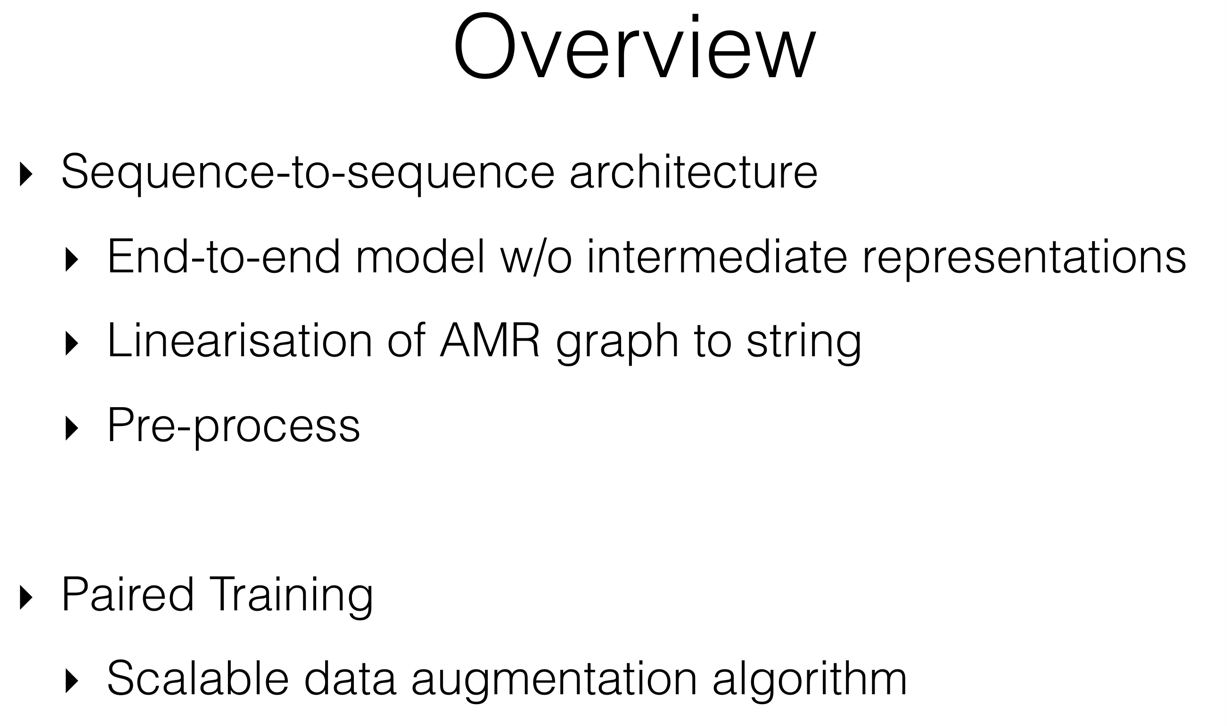

In [29]:
def token2text(input_ids,vocab_list):
    for token_id in input_ids:
        for iid in token_id:
            print(vocab_list[int(iid)])

token2text(list(np.array(encoding["input_ids"])),vocab_list)

[CLS]
overview
»
sequence
-
to
-
sequence
architecture
»
end
-
to
-
end
model
w
/
o
intermediate
representations
»
linear
##isation
of
am
##r
graph
to
string
»
pre
-
process
»
paired
training
>
»
scala
##ble
data
aug
##ment
##ation
algorithm
[SEP]


效果好的一批，就牛逼

### 例2：document image classification (training, inference) + token classification (inference), apply_ocr=False

若自己使用其他OCR的引擎，可以将apply_ocr=False来初始化特征，需要自己向Processor提供words和normalized bbox

In [ ]:
from transformers import LayoutLMv2Processor
from PIL import Image

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

image = Image.open("name_of_your_document - can be a png file, pdf, etc.").convert("RGB")
words = ["hello", "world"]
boxes = [[1, 2, 3, 4], [5, 6, 7, 8]] # make sure to normalize your bounding boxes
encoding = processor(image, words, boxes=boxes, return_tensors="pt")
print(encoding.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

### 例3：token classification (training), apply_ocr=False

对于token classificatio task-序列标注任务（例如 FUNSD、CORD、SROIE、Kleister-NDA），还可以提供相应的word labels以训练模型。 然后processor会将这些转换为token-level labels。 默认情况下，它只会标记the first wordpiece of a word，并将剩余的wordpieces标记为 -100(是 PyTorch 的 CrossEntropyLoss 的 ignore_index)
如果您想要标记a word的all wordpieces，您可以使用 only_label_first_subword 设置为 False 来初始化标记器

In [ ]:
from transformers import LayoutLMv2Processor
from PIL import Image

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

image = Image.open("name_of_your_document - can be a png file, pdf, etc.").convert("RGB")
words = ["hello", "world"]
boxes = [[1, 2, 3, 4], [5, 6, 7, 8]] # make sure to normalize your bounding boxes
word_labels = [1, 2]
encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
print(encoding.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

### 例4：visual question answering (inference), apply_ocr=True

对于视觉问答任务（例如DocVQA），您可以向processor提供问题。 默认情况下，processor将对图像应用 OCR，并创建 [CLS] 问题标记 [SEP] 单词标记 [SEP]。

In [ ]:
from transformers import LayoutLMv2Processor
from PIL import Image

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

image = Image.open("name_of_your_document - can be a png file, pdf, etc.").convert("RGB")
question = "What's his name?"
encoding = processor(image, question, return_tensors="pt")
print(encoding.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

### 例5：visual question answering (inference), apply_ocr=False

对于视觉问答任务（例如DocVQA），您可以向processor提供问题。 如果您想自己执行 OCR，您可以向processor提供您自己的words和normalized bbox

In [ ]:
from transformers import LayoutLMv2Processor
from PIL import Image

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

image = Image.open("name_of_your_document - can be a png file, pdf, etc.").convert("RGB")
question = "What's his name?"
words = ["hello", "world"]
boxes = [[1, 2, 3, 4], [5, 6, 7, 8]] # make sure to normalize your bounding boxes
encoding = processor(image, question, words, boxes=boxes, return_tensors="pt")
print(encoding.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

## LayoutLMv2Config

这是用于store LayoutLMv2Model config的类。 它用于根据指定的参数实例化 LayoutLMv2 模型，定义模型架构。 使用默认值实例化配置将产生与 LayoutLMv2 microsoft/layoutlmv2-base-uncased 架构类似的配置。

配置对象继承自 PretrainedConfig，用于控制模型输出

In [ ]:
class transformers.LayoutLMv2Config(vocab_size=30522, 
                                    hidden_size=768, 
                                    num_hidden_layers=12, 
                                    num_attention_heads=12, 
                                    intermediate_size=3072, 
                                    hidden_act='gelu', 
                                    hidden_dropout_prob=0.1, 
                                    attention_probs_dropout_prob=0.1, 
                                    max_position_embeddings=512, 
                                    type_vocab_size=2, 
                                    initializer_range=0.02, 
                                    layer_norm_eps=1e-12, 
                                    pad_token_id=0, 
                                    max_2d_position_embeddings=1024, 
                                    max_rel_pos=128, 
                                    rel_pos_bins=32, 
                                    fast_qkv=True, 
                                    max_rel_2d_pos=256, 
                                    rel_2d_pos_bins=64, 
                                    convert_sync_batchnorm=True, 
                                    image_feature_pool_shape=[7, 7, 256], 
                                    coordinate_size=128, 
                                    shape_size=128, 
                                    has_relative_attention_bias=True, 
                                    has_spatial_attention_bias=True, 
                                    has_visual_segment_embedding=False,
                                    detectron2_config_args=None, **kwargs)

Parameters

    vocab_size (int, optional, defaults to 30522) – Vocabulary size of the LayoutLMv2 model.
    hidden_size (int, optional, defaults to 768) – encoder layers and pooler layer的维度
    num_hidden_layers (int, optional, defaults to 12) – Transformer encoder隐藏层的数目
    num_attention_heads (int, optional, defaults to 12) – Transformer encoder每个注意力层的注意力头数
    intermediate_size (int, optional, defaults to 3072) – Transformer encoder中间层的维度(feed-forward前馈层) 
    hidden_act (str or function, optional, defaults to "gelu") – encoder and pooler中的非线性激活函数(function or string)If string, "gelu", "relu", "selu" and "gelu_new" are supported.
    hidden_dropout_prob (float, optional, defaults to 0.1) – embeddings, encoder, and pooler中所有全连接层的dropout概率。
    attention_probs_dropout_prob (float, optional, defaults to 0.1) – The dropout ratio for the attention probabilities.
    max_position_embeddings (int, optional, defaults to 512) – 该模型可能使用的最大序列长度。 通常将其设置为较大的值以防万一（例如，512 或 1024 或 2048）。
    type_vocab_size (int, optional, defaults to 2) – 调用 LayoutLMv2Model 或 TFLayoutLMv2Model 时传递的 token_type_ids 的词汇量大小。
    initializer_range (float, optional, defaults to 0.02) – 用于初始化所有权重矩阵的 truncated_normal_initializer 的标准偏差。
    layer_norm_eps (float, optional, defaults to 1e-12) – The epsilon used by the layer normalization layers.
    max_2d_position_embeddings (int, optional, defaults to 1024) – 二维位置嵌入可能使用的最大值。 通常将其设置为大的以防万一（例如，1024）。
    max_rel_pos (int, optional, defaults to 128) – 在自注意力机制中使用的最大相对位置（relative positions）数。
    rel_pos_bins (int, optional, defaults to 32) – The number of relative position bins to be used in the self-attention mechanism.
    fast_qkv (bool, optional, defaults to True) – 是否对自注意力层中的queries, keys, values使用单个矩阵。
    max_rel_2d_pos (int, optional, defaults to 256) – self-attention 机制中相对 2D 位置的最大数量。
    rel_2d_pos_bins (int, optional, defaults to 64) – The number of 2D relative position bins in the self attention mechanism.
    image_feature_pool_shape (List[int], optional, defaults to [7, 7, 256]) – 平均池化特征图的形状
    coordinate_size (int, optional, defaults to 128) – Dimension of the coordinate embeddings.
    shape_size (int, optional, defaults to 128) – Dimension of the width and height embeddings.
    has_relative_attention_bias (bool, optional, defaults to True) – 是否在自注意力机制中使用 relative attention bias。
    has_spatial_attention_bias (bool, optional, defaults to True) – 是否在自注意力机制中使用空间注意力偏差spatial attention bias。
    has_visual_segment_embedding (bool, optional, defaults to False) – 是否添加视觉片段嵌入visual segment embeddings
    detectron2_config_args (dict, optional) – 包含 Detectron2 visual backbone配置参数的字典

In [ ]:
from transformers import LayoutLMv2Model, LayoutLMv2Config
# Initializing a LayoutLMv2 microsoft/layoutlmv2-base-uncased style configuration
configuration = LayoutLMv2Config()
# Initializing a model from the microsoft/layoutlmv2-base-uncased style configuration
model = LayoutLMv2Model(configuration)
# Accessing the model configuration
configuration = model.config

## LayoutLMv2FeatureExtractor

Main method to prepare for the model one or several image(s).

In [ ]:
class transformers.LayoutLMv2FeatureExtractor(do_resize=True, size=224, resample=2, apply_ocr=True, **kwargs)

构造一个 LayoutLMv2 特征提取器。 这可用于将文档图像调整为相同大小，以及对其应用 OCR 以获得单词列表和规范化边界框。

此特征提取器继承自包含大部分主要方法的 PreTrainedFeatureExtractor。 用户应该参考这个超类以获取有关这些方法的更多信息

Parameters

    do_resize (bool, optional, defaults to True) – 是否将输入调整为特定大小
    
    size (int or Tuple(int), optional, defaults to 224) – 将输入调整为给定的大小。 如果提供了一个元组，它应该是 (width, height)。 如果只提供了一个整数，那么输入将被调整为 (size, size)。 仅当 do_resize 设置为 True 时才有效
    
    resample (int, optional, defaults to PIL.Image.BILINEAR) – 一个可选的重采样过滤器。 这可以是 PIL.Image.NEAREST、PIL.Image.BOX、PIL.Image.BILINEAR、PIL.Image.HAMMING、PIL.Image.BICUBIC 或 PIL.Image.LANCZOS 之一。 仅当 do_resize 设置为 True 时才有效
    
    apply_ocr (bool, optional, defaults to True) –是否应用 Tesseract OCR 引擎获取words + normalized bounding boxes.
LayoutLMv2FeatureExtractor uses Google’s Tesseract OCR engine under the hood(在底层).

In [ ]:
__call__(images: Union[PIL.Image.Image, numpy.ndarray, torch.Tensor, List[PIL.Image.Image], List[numpy.ndarray], List[torch.Tensor]], return_tensors: Optional[Union[str, transformers.file_utils.TensorType]] = None, **kwargs) → transformers.feature_extraction_utils.BatchFeature

Parameters

    images (PIL.Image.Image, np.ndarray, torch.Tensor, List[PIL.Image.Image], List[np.ndarray], List[torch.Tensor]) – 要准备的图像或一批图像。 每个图像可以是 PIL 图像、NumPy 数组或 PyTorch 张量。 对于 NumPy 数组/PyTorch 张量，每个图像的形状应为 (C, H, W)，其中 C 是通道数，H 和 W 是图像的高度和宽度。

    return_tensors (str or TensorType, optional, defaults to 'np') –

    如果设置，将返回特定框架的张量。 可接受的值为：

    'tf'：返回 TensorFlow tf.constant 对象。

    'pt'：返回 PyTorch torch.Tensor 对象。

    'np'：返回 NumPy np.ndarray 对象。

    'jax'：返回 JAX jnp.ndarray 对象。

Returns

    具有以下字段的 BatchFeature：

    pixel_values – 要fed给模型的像素值，shape是（batch_size、num_channels、height、width）。

    words – Tesseract OCR 标识的Optional words（仅当 LayoutLMv2FeatureExtractor 初始化时 apply_ocr 设置为 True）。

    boxes – 由 Tesseract OCR 识别的Optional bounding boxes，根据图像大小标准化（仅当 LayoutLMv2FeatureExtractor 初始化时 apply_ocr 设置为 True）。
Return type

    BatchFeature

In [ ]:
# example
from transformers import LayoutLMv2FeatureExtractor
from PIL import Image

image = Image.open("name_of_your_document - can be a png file, pdf, etc.").convert("RGB")

# option 1: with apply_ocr=True (default)
feature_extractor = LayoutLMv2FeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
print(encoding.keys())
# dict_keys(['pixel_values', 'words', 'boxes'])

# option 2: with apply_ocr=False
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
encoding = feature_extractor(image, return_tensors="pt")
print(encoding.keys())
# dict_keys(['pixel_values'])

## LayoutLMv2Tokenizer

Main method to tokenize and prepare for the model one or several sequence(s) or one or several pair(s) of sequences with word-level normalized bounding boxes and optional labels.

In [ ]:
classtransformers.LayoutLMv2Tokenizer(vocab_file, 
                                      do_lower_case=True, 
                                      do_basic_tokenize=True, 
                                      never_split=None, 
                                      unk_token='[UNK]', 
                                      sep_token='[SEP]', 
                                      pad_token='[PAD]', 
                                      cls_token='[CLS]', 
                                      mask_token='[MASK]', 
                                      cls_token_box=[0, 0, 0, 0], 
                                      sep_token_box=[1000, 1000, 1000, 1000], 
                                      pad_token_box=[0, 0, 0, 0], 
                                      pad_token_label=- 100, 
                                      only_label_first_subword=True, 
                                      tokenize_chinese_chars=True, 
                                      strip_accents=None, 
                                      model_max_length: int = 512, 
                                      additional_special_tokens: Optional[List[str]] = None, **kwargs)

  构建一个 LayoutLMv2 tokenizer。 基于 WordPiece。 LayoutLMv2Tokenizer 可用于turn words, word-level bounding boxes and optional word labels转换为 token-level input_ids、attention_mask、token_type_ids、bbox 和optional labels (for token classification)

  这个分词器继承自包含大部分主要方法的 PreTrainedTokenizer。 用户应该参考这个超类以获取有关这些方法的更多信息

  LayoutLMv2Tokenizer runs end-to-end tokenization：punctuation标点分割和wordpiece。 它还将word-level bounding boxes转换为 token-level bounding boxes

In [ ]:
__call__(text: Union[str, List[str], List[List[str]]], 
         text_pair: Optional[Union[List[str], List[List[str]]]] = None, 
         boxes: Union[List[List[int]], List[List[List[int]]]] = None, 
         word_labels: Optional[Union[List[int], List[List[int]]]] = None, 
         add_special_tokens: bool = True, 
         padding: Union[bool, str, transformers.file_utils.PaddingStrategy] = False, 
         truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = False, 
         max_length: Optional[int] = None, 
         stride: int = 0, 
         pad_to_multiple_of: Optional[int] = None, 
         return_tensors: Optional[Union[str, transformers.file_utils.TensorType]] = None, 
         return_token_type_ids: Optional[bool] = None, 
         return_attention_mask: Optional[bool] = None, 
         return_overflowing_tokens: bool = False, 
         return_special_tokens_mask: bool = False, 
         return_offsets_mapping: bool = False, 
         return_length: bool = False, verbose: bool = True, **kwargs) 
→ transformers.tokenization_utils_base.BatchEncoding

Parameters

    

## others

# Leveraging PTMs Checkpoints for seq2seq